# A notebook for the Kaggle NLP competition
Competition Page: https://www.kaggle.com/competitions/nlp-getting-started/data?select=test.csv

Mostly following the tutorial: https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook

## Importing things

### Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

### Importing the training set and saving it as train_df

In [2]:
train_df = pd.read_csv('train.csv', index_col= 0)
train_df.drop("keyword", axis= 1, inplace = True) #Dropping keyword because I want to the model to pick up on keywords
train_df

,location,text,target
id,,,
1,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
10869,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


### Importing test set just like the training set

In [3]:
test_df = pd.read_csv('test.csv', index_col= 0)
test_df.drop("keyword", axis= 1, inplace = True) #Dropping keyword because I want to the model to pick up on keywords
test_df

,location,text
id,,
0,NaN,Just happened a terrible car crash
2,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10865,NaN,Storm in RI worse than last hurricane. My city...
10868,NaN,Green Line derailment in Chicago http://t.co/U...


## Done with importing and now doing pre-processing for training

### Now we need to tokenize the text so that it can be processed by machine learning algorithms
We are doing this from scratch by using CountVectorizer from sklearn.
It works by being given a list of texts in fit_transform(). It then associates each unique word to a number and then keeps track of which words (tokens) appeared in a string and how many times. Different settings are available but just using the default ones.

In [4]:
count_vectorizer = feature_extraction.text.CountVectorizer()

# Using fit transform to "train" the tokenizer on our training set
train_vectors = count_vectorizer.fit_transform(train_df["text"])

# Using just "transform" because we don't want to add new tokens not present in the original tokenization. This will give us a list of the strings
# as their tokenized versions (essentially as vectors marking whether or not a given token is present in the text)
test_vectors = count_vectorizer.transform(test_df["text"])

train_vectors

<7613x21637 sparse matrix of type '<class 'numpy.int64'>'
	with 111497 stored elements in Compressed Sparse Row format>

### We are using Ridge Regression.
Because "Our vectors are really big, so we want to push our model's weightstoward 0 without completely discounting different words"
This is because there are 20,000+ tokens (their presence, i.e. 0 or 1, is the variables) but less than 8,000 samples (each tweet) to train on.
So we need certain weights to drop to 0 and ridge regression is a way to do that in a linear model.

In [5]:
clf = linear_model.RidgeClassifier()

### We are using CV (cross validation) to train and test how well the model fits.
cross_val_score is doing the training using clf (the Ridge Classifier), with train_vectors as the inputs, and train_df as the outputs.
We can change the number of CVs being done by changing "cv", and scoring is the metric being used to score the overall results per CV.

The F1 metric is a good metric when the number of positives and negatives are balanced, and in this case there's 57% positives and 43% negatives so it's an acceptable metric. 

The F1 metric is the harmonic mean between the Precision and Recall. 

Precision is the number of TRUE positives predicted divided by the total number of predicted positives. In other words, how precise was it when it guessed something was positive.

Recall is the number of TRUE positives divided by the total number of positives. In other words, how good was it at "recalling" the actual positives.

I believe it uses the harmonic mean because it essentially works to penalize preferring one over the other. You get a lower score the farther apart the two scores are. Consider these examples: F1(0.5,0.5) = 0.5 but F1(0.25, 0.75) =  0.375 and F1(0.1, 0.9) = 0.18 despite all having the same arithmetic mean. It encourages learning a good fit that works for recall and precision. 

Note that an imbalance like having 5 positives to 95 negatives would make the F1 score less reliable F1 scores are mostly a metric determining how good a model is at determining positives. A high F1 might not necessarily mean it's a good model at determining negatives and a low F1 might be good at determining negatives. This is less drastic when there's an equal balance.

In [6]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=5, scoring="f1")
scores

array([0.6025641 , 0.50168919, 0.56985004, 0.50781969, 0.67275495])

In [7]:
len(train_df[train_df["target"] == 0])/len(train_df) 
#Looking at the proportion of disaster to non-disaster tweets. 57% are NOT about disasters and 43% are.

0.5703402075397347

In [8]:
from random import random
def rand_pred(data):
    ans = [0] * len(data)
    for i in range(len(data)):
        r = random()
        if r > 0.5:
            ans[i] = 0
        else:
            ans[i] = 1
    return ans

temp = 0
for i in range(100):
    temp += metrics.f1_score(train_df["target"], rand_pred(train_df["target"]))
print("Average baseline F1 (randomly guessing) is:", temp/100)

print("Average F1 using our simple model is:", scores.mean())

Average baseline F1 (randomly guessing) is: 0.4611921954241734
Average F1 using our simple model is: 0.5709355930313303


#### The mean F1 for our simple model is 0.57 which is quite poor when our mean baseline is 0.46 with random guessing. Meaning there's room for improvement.

# Doing my own independent analysis

### Creating another matrix for the words instead of CountVectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Previously we were using countvectorizer which weights all words the same. Instead we'll use TF-IDF to determine how relevant certain terms are. 
#This should make common words like "a" and "the" less important and improve our model. We'll also use min_df = 2.
#This is so we only consider words that show up more than once. This should help reduce the "noise"

tfidf_vectorizer = TfidfVectorizer(min_df = 2)

# Using fit_transform to "train" the tokenizer on our training set
train_vectors = tfidf_vectorizer.fit_transform(train_df["text"])

# Same as before
test_vectors = tfidf_vectorizer.transform(test_df["text"])


#We go from over 20,000 tokens being considered down to only 6,500.
#There's still 7613 rows of data (each row corresponds to a tweet)
train_vectors

<7613x6594 sparse matrix of type '<class 'numpy.float64'>'
	with 96454 stored elements in Compressed Sparse Row format>

### Applying LSA to our new matrix
Now that we have a matrix with fewer words we'll apply a second trick: LSA (Latent Semantic Analysis)
Essentially we're applying SVD (Singular Value Decomposition) to extract the most important information in the form of uncorrelated vectors.

We do this because the dimensionality is still high and we might get better results by essentially ignoring noisy components of the word-matrix.

In [10]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

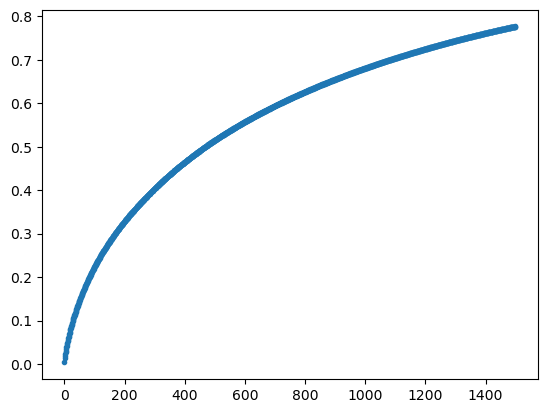

In [11]:
from sklearn.decomposition import TruncatedSVD

comp_used = 1500 #With just 1500 out of 6500+ possible components used we can explain 78% of the variance.
#With 1000 components we can explain 68% of the variance

svd = TruncatedSVD(n_components = comp_used, random_state = 1) #Initializing the SVD settings. We intend to keep comp_used components

svd.fit(train_vectors) #Using the SVD settings from before to fit our matrix into the SVD model. We can then use transform to "apply" it to other matrices
#Not 100% sure how it works but I believe when using transform it calculates the new U times singular value matrix BUT uses the same V. 

import matplotlib.pyplot as plt
%matplotlib inline

c = Cumulative(svd.explained_variance_)
plt.plot(range(len(svd.explained_variance_)), c, '.') #A plot of variance explained vs number of components used


In [12]:
lsa = svd.transform(train_vectors)
new_df = pd.DataFrame(lsa, columns = ["Vibe " + str(x) for x in range(comp_used)])

In [13]:
new_df

,Vibe 0,Vibe 1,Vibe 2,Vibe 3,Vibe 4,Vibe 5,Vibe 6,Vibe 7,Vibe 8,Vibe 9,...,Vibe 1490,Vibe 1491,Vibe 1492,Vibe 1493,Vibe 1494,Vibe 1495,Vibe 1496,Vibe 1497,Vibe 1498,Vibe 1499
0,0.123695,-0.076812,-0.065732,0.039466,-0.008469,0.028076,-0.005293,0.015532,0.015263,0.056535,...,0.008134,-0.015763,0.008303,0.004257,-0.010204,0.018251,0.008990,-0.007367,0.003673,0.008113
1,0.032238,0.007717,-0.007092,-0.017509,-0.011302,-0.018214,-0.004537,0.043293,-0.018210,-0.038303,...,-0.002416,0.007575,0.013680,0.006118,-0.002497,0.002249,-0.010931,0.025720,0.004415,0.010532
2,0.112848,-0.044965,0.030970,-0.034073,0.008181,0.106694,0.070236,-0.048470,0.019847,-0.012253,...,-0.006296,0.003257,0.013892,0.000018,-0.011857,-0.018313,0.014000,-0.008357,-0.001561,0.023044
3,0.053412,0.013121,-0.008879,-0.013307,0.011640,0.084006,0.029897,0.002754,0.022094,-0.084828,...,0.006495,0.002283,0.003508,0.015439,0.004136,0.005085,-0.018924,-0.004089,-0.010166,0.000742
4,0.089431,-0.033610,0.003855,-0.065129,-0.060234,-0.065846,0.118765,0.127133,0.045550,0.043558,...,0.021303,0.015785,0.014394,-0.007818,0.004293,-0.009337,0.002034,0.002640,-0.031482,-0.003046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.108107,0.114591,0.017769,0.012042,0.075304,-0.007515,0.003125,0.004276,-0.001192,-0.065242,...,-0.000192,0.000303,0.000364,-0.003584,0.000347,0.004988,-0.000424,-0.000096,0.002065,-0.002527
7609,0.217408,-0.078725,-0.214217,0.091613,0.015109,0.148465,0.003717,-0.029794,0.054123,-0.071817,...,0.022492,0.000224,-0.012210,-0.001652,-0.004444,-0.005154,-0.001189,0.003609,0.000538,0.005496
7610,0.087444,0.068206,-0.018453,0.018300,-0.022020,-0.017594,-0.000933,-0.017074,-0.008847,0.021709,...,0.008754,-0.005410,-0.008524,0.003947,-0.014036,-0.002095,-0.001111,0.005766,0.022158,-0.013311
7611,0.059815,-0.011268,0.005581,-0.036103,-0.036063,0.064492,0.008623,-0.016302,-0.001937,-0.029510,...,-0.001406,0.016577,0.009069,-0.012915,-0.008252,0.005499,0.011047,0.007959,0.024987,-0.029427


In [14]:
import numpy
numpy.transpose(svd.components_) #svd.components_ is V transpose so to get the V vectors we transpose it again back to V.

array([[ 0.00453036,  0.00633764, -0.00015672, ..., -0.03007632,
        -0.01485266,  0.00040821],
       [ 0.00085999, -0.00106542, -0.00049417, ..., -0.00498775,
        -0.00339303, -0.00768412],
       [ 0.00253013,  0.0047389 , -0.00114741, ...,  0.00842382,
        -0.02661088,  0.0037713 ],
       ...,
       [ 0.00060676, -0.00042337, -0.00082153, ...,  0.00080718,
        -0.00231682,  0.00589392],
       [ 0.01104632,  0.01029113,  0.00320628, ..., -0.01544747,
         0.00728811, -0.01764988],
       [ 0.00820507,  0.00118274, -0.00330354, ..., -0.01180676,
        -0.00315899,  0.01075624]])

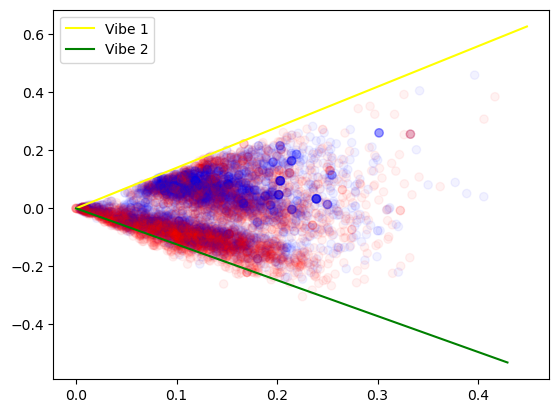

In [15]:
#If the text was about a disaster then it'll be colored blue otherwise it'll be red
colors = {0:'red', 1:'blue'}

#Plotting each tweet along the new axis defined by the LSA components (in 2D). These are the singular values multiplied by the U matrix.
#They're also colored depending on whether they correspond to a disaster or not.
plt.scatter(list(numpy.transpose(lsa)[0]), list(numpy.transpose(lsa)[1]), c= list(train_df['target'].map(colors).values), alpha = 0.05)

#Plotting the first and second principle components as a yellow and green line respectively to aid in visualization.
plt.plot(svd.components_[0][0]*range(100), svd.components_[1][0]*range(100), c = "yellow", label = "Vibe 1")
plt.plot(svd.components_[0][1]*range(500), svd.components_[1][1]*range(500), c = "green", label = "Vibe 2")
plt.legend(loc='upper left')

#We can see that the LSA appears to be working correctly and that there seems to be some clumping occurring already.

In [16]:
#Looking at the V matrix.

pd.DataFrame(data = [svd.components_[0],svd.components_[1]])
#The first column is the direction (in 2D) of the main component. Second column is the direction for the 2nd most relevant component and so on.
#We can increase the "dimension" by looking at more 

,0,1,2,3,4,5,6,7,8,9,...,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593
0,0.004530,0.000860,0.002530,0.001579,0.001110,0.000078,0.001622,0.005044,0.003295,0.002740,...,0.000663,0.000626,0.001188,0.000733,0.001380,0.000827,0.003530,0.000607,0.011046,0.008205
1,0.006338,-0.001065,0.004739,0.001906,0.001033,-0.000020,0.002671,0.006764,0.006508,0.003283,...,-0.000476,0.001079,-0.000066,0.001469,0.000756,0.000399,0.000437,-0.000423,0.010291,0.001183


In [17]:
#Looking at the first 3 columns of the LSA matrix (U times singular values) along with the texts and their targets.
#We are sorting by the first column to see if there's any similiarities visible.

temp = pd.DataFrame(lsa[:,:3])
temp['text'] = train_df['text'].reset_index(drop=True)
temp['target'] = train_df['target'].reset_index(drop=True)


temp.sort_values(0, ascending=False)

#We can already see some latent similarities emerging. The top texts all contain links while the last ones don't and are quite informal

,0,1,2,text,target
4367,0.416719,0.384985,0.133106,How to remove http://t.co/HRSfA8zujI BrowseråÊ...,0
4101,0.405814,0.307777,-0.045810,Hail The New Caesars! http://t.co/GzMoBlsJxu h...,0
5286,0.405632,0.040237,-0.267158,A Mad Catastrophe : The Outbreak of World War ...,1
6593,0.396511,0.459629,0.073873,Remembrance http://t.co/ii4EwE1QIr #Hiroshima...,1
3549,0.388600,0.051209,-0.145361,A memorial to the millions who perished in the...,1
...,...,...,...,...,...
640,0.000000,0.000000,0.000000,@Kaotix_Blaze craving u,0
5115,0.000000,0.000000,0.000000,Err:509,0
24,0.000000,0.000000,0.000000,LOOOOOOL,0
823,0.000000,0.000000,0.000000,@Blizzard_Gamin ight,0


### Fitting different models using the LSA representation

In [18]:
#Using a RidgeClassifier again to compare results.

clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, lsa, train_df["target"], cv=5, scoring="f1")
scores

array([0.60837209, 0.55200655, 0.61335532, 0.62147887, 0.69984448])

In [19]:
scores.mean()

0.6190114629337599

The original scores are: array([0.6025641 , 0.50168919, 0.56985004, 0.50781969, 0.67275495]) 

-> **Ridge no LSA Mean = 0.57**, median = 0.57

The new scores are: array([0.60837209, 0.55200655, 0.61335532, 0.62147887, 0.69984448]) 

-> **Ridge w/ LSA Mean = 0.62**, median = 0.61

{'whiskers': [<matplotlib.lines.Line2D at 0x1a833b82310>,
 'caps': [<matplotlib.lines.Line2D at 0x1a83377e2d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a833b60190>,
 'medians': [<matplotlib.lines.Line2D at 0x1a8337dfad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a833b82010>,
 'means': []}

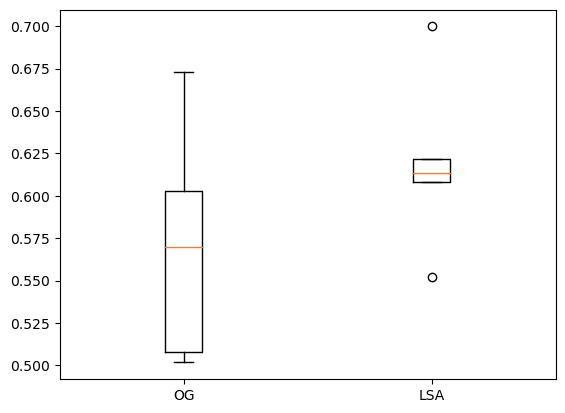

In [20]:
plt.boxplot([[0.6025641 , 0.50168919, 0.56985004, 0.50781969, 0.67275495], [0.60837209, 0.55200655, 0.61335532, 0.62147887, 0.69984448]],
           labels = ["OG", "LSA"])

#### Logistic Regression

In [21]:
lr = linear_model.LogisticRegression()

scores = model_selection.cross_val_score(lr, lsa, train_df["target"], cv=5, scoring="f1")
print(scores, "Mean is:", scores.mean())

[0.62715105 0.60052678 0.64231096 0.60092166 0.73205742] Mean is: 0.640593572964531


**LogisticRegression Mean: 0.64**

**Kaggle Score: 0.79497**

**Default benchmark score is 0.78179** so not that much better.

In [22]:
#Submitting it to see how good the score is
lr.fit(lsa, train_df["target"])
logit_sub = pd.DataFrame(lr.predict(svd.transform(test_vectors)), columns = ["target"]).set_index(test_df.index).to_csv("submission.csv")